In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
import numpy as np
from random import random, uniform, choice, randint
from time import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys

num_digits = 3

'''
Class to implement genetic algorithm to minimization
using truncation selection.
'''
class GA:
  '''
  Constructor method of class GA
  --- Required args ---
  fitness: The function used to get the fitness of a population
  parameters:  dictionary the parameters being minimized. 
                It must contain the name and limits in the format "name: (lower, upper)".
  populationSize: population size.
  maxGen: max number of generations
  --- Optional args ---
  retain: the percentage of elements retained in the truncation. Must be between 0 and 1.
  random_select: the chance of random selection of an individual. Must be between 0 and 1.
  mutate: the chance of mutating an individual. Must be between 0 and 1.
  '''
  def __init__(self, fitness, parameters, populationSize, maxGen,
               retain=0.2, random_select=0.05, mutate=0.01):
    self.fitness = fitness
    self.parametersRange = list(parameters.values())
    self.populationSize = populationSize
    self.maxGen = maxGen
    self.retain = retain
    self.random_select = random_select
    self.mutate = mutate
    self.history = {}
    self.stop = False
  
  '''
  Create a member of the population.
  '''
  def individual(self):
    return [round(uniform(*parameter), num_digits) if type(parameter) == tuple else choice(parameter)
            for parameter in self.parametersRange]

  '''
  Create a number of individuals i.e. a population.
  '''
  def population(self, count):
    pop = []
    while len(pop) < count:
      ind = self.individual()
      if ind not in pop:
        pop.append(ind)
    return pop

  '''
  Find minimum fitness for a population.
  '''
  def grade(self, list_fit=None):
    if not list_fit:
      list_fit = self.fit
    try:
      return np.nanmin([fit for fit in self.fit])
    except:
      return np.nan

  def evaluate_individual(self, individual):
    individual_tuple = tuple(individual)
    if individual_tuple not in self.history:
      fitness = self.fitness(individual)
      if np.isnan(fitness):
        fitness = self.fitness(individual)
      self.history[individual_tuple] = fitness
    return self.history[individual_tuple]

  def evaluate_population(self, population):
    return [self.evaluate_individual(individual) for individual in tqdm(population, desc="    Evaluating", file=sys.stdout)]

  def evolve(self):
    retain_length = int(self.populationSize*self.retain)
    parents = [ind for ind in tqdm(self.pop[:retain_length], desc="    Retain", file=sys.stdout)]
    
    # randomly add other individuals to
    # promote genetic diversity
    for individual in tqdm(self.pop[retain_length:], desc="    Random", file=sys.stdout):
      if self.random_select > random():
        parents.append(individual)
            
    # mutate some individuals
    for individual in tqdm(parents, desc="    Mutation", file=sys.stdout):
      if self.mutate > random():
        pos_to_mutate = randint(0, len(individual)-1)
        parameter = self.parametersRange[pos_to_mutate]
        individual[pos_to_mutate] = uniform(*parameter) if type(parameter) == tuple else choice(parameter)
    
    desired_length = self.populationSize - len(parents)
    # check if GA has already converged
    # if number of different elements <= 20%, stop.
    unique = np.unique(self.pop, axis=0)
    if(len(unique) < 2):
      # self.stop = True
      print("  # of different elements < 2")
      extend = [self.pop[0]] * desired_length
      parents.extend(extend)
    else:
      # crossover parents to create children
      children = []
      cont = 0
      while len(children) < desired_length:
          male, female = choice(parents), choice(parents)
          cont = 0
          while male == female:
            cont += 1
            female = choice(parents)
            if cont > 1000:
              female = self.individual()
          position = randint(1, len(male)-1)
          child1 = male[:position] + female[position:]
          child2 = female[:position] + male[position:]
          children.append(child1)  
          children.append(child2)
      parents.extend(children)
      print("    Crossover: OK")

    # organizing the new population
    parents = sorted(parents[:self.populationSize])
    print("    New Population:", parents)

    # evaluating new population
    new_fit = self.evaluate_population(parents)

    new_best = self.grade(new_fit)
    print("    Best fitness of this generation:", new_best)

    # # if the new best is bigger than the old one by 60% or higher, stop.
    # if((new_best - self.best_fit)/self.best_fit >= 0.6):
    #   print("  Stopping due to: moving out from convergence")
    #   self.stop = True
    #   return self.best_fit

    # sorting the new population by fitness
    self.fit, self.pop = [list(t) for t in zip(*sorted(zip(new_fit, parents)))]
    self.best_fit = new_best

    # # check if GA has already converged
    # # if number of different elements <= 20%, stop.
    # unique = np.unique(self.pop, axis=0)
    # if(len(unique) <= (0.2 * self.populationSize)):
    #   self.stop = True
    #   print("  Stopping due to: # different elements <= 20%")

    # elif(self.best_fit <= 1e-3):
    #   print("  Stopping due to: convergence")
    #   self.stop = True

    # elif(np.isnan(self.best_fit)):
    #   print("  Stopping due to: best fitness is NaN")
    #   self.stop = True
        
    return self.best_fit

  def report(self, grade_history):
      best_index = self.fit.index(min(self.fit))
      best = {'gene': self.pop[best_index], 'loss': self.fit[best_index]}
      return best, grade_history

  def plot(self, hist, op="show", name=None, lang='en'):
    x = [i+1 for i in range(len(hist))]
    y = hist
    # English
    plt.plot(x, y)
    plt.xlabel("# of iterations" if lang == 'en' else "Número de iterações")
    plt.ylabel("Loss")
    if op == "show":
      plt.show()
    else:
      plt.savefig(name)
    plt.gcf().clear()
      
  def run(self):
    self.history = {}
    self.pop = sorted(self.population(self.populationSize))
    print("    Population:", self.pop)
    self.fit = self.evaluate_population(self.pop)
    self.best_fit = self.grade()
    print("    Initial best:", self.best_fit)
    self.fit, self.pop = [list(t) for t in zip(*sorted(zip(self.fit, self.pop)))]
    # self.stop = False
    grade_history = []
    for i in range(self.maxGen):
      print(f"\n  Running generation {(i+1)}/{self.maxGen}")
      t = time()
      grade = self.evolve()
      grade_history.append(grade)
      print("  End of generation.\n  Time elapsed (s):", time() - t)
      # if(self.stop):
      #   break    
    return self.report(grade_history)

Using TensorFlow backend.


4423680/4422102 [==============================] - 0s 0us/step


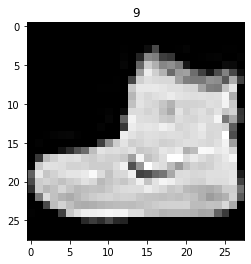

In [3]:
from tensorflow import keras
from keras.datasets import fashion_mnist as dataset

(X_train, y_train), (X_test, y_test) = dataset.load_data()

plt.title(y_train[0])
plt.imshow(X_train[0], cmap='gray')

In [0]:
if X_train.shape[-1] == 3:
  X_train = X_train / 255.
  X_test = X_test / 255.
else:
  X_train = np.expand_dims(X_train, -1) / 255.
  X_test = np.expand_dims(X_test, -1) / 255.

from keras.utils import to_categorical
#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
val_split = int(.2 * len(X_train))
X_train, X_validation = X_train[:-val_split], X_train[-val_split:]
y_train, y_validation = y_train[:-val_split], y_train[-val_split:]

In [0]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
# from keras.optimizers import Adam

from dataclasses import dataclass

@dataclass
class ImageRecognition:
  X_train: np.ndarray 
  y_train: np.ndarray
  X_validation: np.ndarray
  y_validation: np.ndarray
  X_test: np.ndarray
  y_test: np.ndarray
  shape: tuple
  num_classes: int = 10

  def clear(self):
    K.clear_session()
    tf.compat.v1.reset_default_graph()

  def configureArchitecture(self, individual):
    num_layer1, num_layer2, num_layer3, dropout, lr, optimizer = individual
    optimizer_ = keras.optimizers.__dict__[optimizer]

    model = Sequential()
    model.add(Conv2D(2**num_layer1, (5, 5), input_shape=self.shape, activation='relu'))
    if num_layer2 > 0:
      model.add(Conv2D(2**num_layer2, (5, 5), activation='relu'))
    if num_layer3 > 0:
      model.add(Conv2D(2**num_layer3, (5, 5), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(self.num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer_(lr), 
                  metrics=['accuracy'])
    
    return model

  def fitness(self, individual, test=False, batch_size=1000, epochs=10):
    self.clear()
    model = self.configureArchitecture(individual)
    model.fit(self.X_train, self.y_train, 
              validation_data=(self.X_validation, self.y_validation), 
              epochs=epochs, batch_size=batch_size, verbose=0)
    results = model.evaluate(self.X_validation, self.y_validation, batch_size, verbose=int(test)) \
              if not test else \
              model.evaluate(self.X_test, self.y_test, batch_size, verbose=int(test))
    return results[0]

In [0]:
from collections import OrderedDict
# from keras.optimizers import Adam, Adadelta, Adagrad, Adamax, SGD, RMSprop

params = OrderedDict([
    ('num_layer1', np.arange(7)),
    ('num_layer2', np.arange(7)),
    ('num_layer3', np.arange(7)),
    ('dropout', np.arange(0, .7, .1)),
    ('lr', np.arange(0.01, 0.1, .01)),
    ('optimizer', ['Adam','Adadelta','Adagrad','Adamax','SGD','RMSprop'])
])

In [0]:
imgRecog = ImageRecognition(X_train, y_train, 
                            X_validation, y_validation, 
                            X_test, y_test,
                            shape=X_train[0].shape)

In [0]:
def run(num_executions=5, batch_size=1000, epochs=5):
    results = []
    loss = []
    for i in range(num_executions):
      print(f"\nRunning execution {(i+1)}/{num_executions}")
      # Run Evolver
      best, hist = evolver.run()
      print('BEST GENE', best['gene'])
      # Calculate loss
      gen_loss = evolver.fitness(best['gene'], test=True, batch_size=batch_size, epochs=epochs)
      print('gen_loss', gen_loss)
      loss.append(gen_loss)
      # Store results
      results.append({
        'best': best,
        'gen_loss': gen_loss,
        'hist': hist, 
        'pop': evolver.pop, 
        'fit': evolver.fit, 
        'history': evolver.history
      })
    return loss, results

In [10]:
%%time
evolver = GA(imgRecog.fitness, params, populationSize=5, maxGen=5)
loss, ga_results = run()


Running execution 1/5
    Population: [[0, 3, 3, 0.2, 0.08, 'Adadelta'], [0, 4, 0, 0.5, 0.04, 'RMSprop'], [2, 0, 4, 0.4, 0.02, 'SGD'], [3, 2, 6, 0.5, 0.09, 'Adamax'], [4, 0, 1, 0.6000000000000001, 0.02, 'Adamax']]



    Initial best: 0.4883081465959549

  Running generation 1/5



    Crossover: OK
    New Population: [[0, 4, 0, 0.5, 0.04, 'RMSprop'], [0, 4, 4, 0.4, 0.02, 'SGD'], [2, 0, 0, 0.5, 0.04, 'RMSprop'], [2, 0, 4, 0.4, 0.02, 'SGD'], [2, 0, 4, 0.4, 0.04, 'RMSprop']]



    Best fitness of this generation: 0.4883081465959549
  End of generation.
  Time elapsed (s): 32.65466380119324

  Running generation 2/5



    Crossover: OK
    New Population: [[2, 0, 0, 0.5, 0.04, 'RMSprop'], [2, 0, 0, 0.5, 0.04, 'RMSprop'], [2, 0, 2, 0.4, 0.09, 'SGD'], [2, 5, 4, 0.1, 0.04, 'Adadelta'], [5, 0, 0, 0.5, 0.04, 'RMSprop']]



    Best fitness of this generation: 0.46430903673171997
  End of generation.
  Time elapsed (s): 43.041505575180054

  Running generation 3/5



    Crossover: OK
    New Population: [[3, 1, 0, 0.5, 0.04, 'RMSprop'], [3, 1, 4, 0.5, 0.04, 'RMSprop'], [5, 0, 0, 0.5, 0.03, 'Adadelta'], [5, 0, 0, 0.5, 0.04, 'RMSprop'], [5, 0, 6, 0.0, 0.03, 'Adamax']]



    Best fitness of this generation: 0.40647540738185245
  End of generation.
  Time elapsed (s): 69.59001803398132

  Running generation 4/5



    Crossover: OK
    New Population: [[5, 0, 0, 0.5, 0.04, 'Adamax'], [5, 0, 0, 0.5, 0.04, 'RMSprop'], [5, 0, 6, 0.0, 0.03, 'Adamax'], [5, 0, 6, 0.0, 0.03, 'RMSprop'], [5, 0, 6, 0.0, 0.03, 'RMSprop']]



    Best fitness of this generation: 0.2903632124265035
  End of generation.
  Time elapsed (s): 47.62624216079712

  Running generation 5/5



    Crossover: OK
    New Population: [[5, 0, 0, 0.0, 0.03, 'Adamax'], [5, 0, 0, 0.5, 0.04, 'Adamax'], [5, 0, 6, 0.0, 0.03, 'Adamax'], [5, 0, 6, 0.5, 0.04, 'Adamax'], [5, 0, 6, 0.5, 0.04, 'Adamax']]



    Best fitness of this generation: 0.2903632124265035
  End of generation.
  Time elapsed (s): 47.748061656951904
BEST GENE [5, 0, 6, 0.0, 0.03, 'Adamax']
10000/10000 [==============================] - 0s 26us/step
gen_loss 0.39398565590381623

Running execution 2/5
    Population: [[1, 5, 0, 0.30000000000000004, 0.08, 'Adam'], [2, 5, 1, 0.4, 0.04, 'RMSprop'], [3, 1, 4, 0.0, 0.01, 'Adam'], [4, 0, 5, 0.6000000000000001, 0.02, 'Adamax'], [4, 5, 4, 0.5, 0.09, 'Adamax']]



    Initial best: 0.261114211132129

  Running generation 1/5



    Crossover: OK
    New Population: [[4, 0, 5, 0.6000000000000001, 0.02, 'Adam'], [4, 0, 5, 0.6000000000000001, 0.02, 'Adam'], [4, 0, 5, 0.6000000000000001, 0.02, 'Adamax'], [4, 4, 6, 0.4, 0.09, 'Adamax'], [5, 0, 2, 0.6000000000000001, 0.02, 'Adamax']]



    Best fitness of this generation: 0.261114211132129
  End of generation.
  Time elapsed (s): 65.77642893791199

  Running generation 2/5



    Crossover: OK
    New Population: [[3, 0, 5, 0.6000000000000001, 0.02, 'Adamax'], [3, 3, 5, 0.6000000000000001, 0.02, 'Adamax'], [4, 0, 4, 0.2, 0.03, 'RMSprop'], [4, 0, 5, 0.6000000000000001, 0.02, 'Adamax'], [4, 4, 4, 0.30000000000000004, 0.08, 'Adagrad']]



    Best fitness of this generation: 0.261114211132129
  End of generation.
  Time elapsed (s): 70.33239150047302

  Running generation 3/5



    Crossover: OK
    New Population: [[4, 0, 0, 0.0, 0.09, 'Adamax'], [4, 0, 5, 0.6000000000000001, 0.02, 'Adamax'], [4, 0, 5, 0.6000000000000001, 0.060000000000000005, 'Adadelta'], [4, 2, 0, 0.30000000000000004, 0.02, 'Adamax'], [5, 2, 5, 0.6000000000000001, 0.02, 'Adamax']]



    Best fitness of this generation: 0.261114211132129
  End of generation.
  Time elapsed (s): 62.09185552597046

  Running generation 4/5



    Crossover: OK
    New Population: [[2, 5, 4, 0.4, 0.02, 'Adamax'], [3, 4, 5, 0.5, 0.02, 'Adamax'], [4, 0, 5, 0.6000000000000001, 0.02, 'Adamax'], [4, 0, 5, 0.6000000000000001, 0.02, 'Adamax'], [4, 0, 5, 0.6000000000000001, 0.08, 'SGD']]



    Best fitness of this generation: 0.261114211132129
  End of generation.
  Time elapsed (s): 61.90266442298889

  Running generation 5/5



    Crossover: OK
    New Population: [[4, 0, 5, 0.30000000000000004, 0.060000000000000005, 'Adagrad'], [4, 0, 5, 0.6000000000000001, 0.02, 'Adamax'], [4, 0, 5, 0.6000000000000001, 0.02, 'SGD'], [4, 6, 4, 0.6000000000000001, 0.02, 'Adamax'], [5, 6, 2, 0.6000000000000001, 0.060000000000000005, 'Adamax']]



    Best fitness of this generation: 0.261114211132129
  End of generation.
  Time elapsed (s): 119.8486065864563
BEST GENE [4, 0, 5, 0.6000000000000001, 0.02, 'Adamax']
10000/10000 [==============================] - 0s 16us/step
gen_loss 0.32217283844947814

Running execution 3/5
    Population: [[0, 0, 0, 0.30000000000000004, 0.02, 'RMSprop'], [0, 6, 5, 0.0, 0.09, 'RMSprop'], [2, 0, 5, 0.1, 0.01, 'Adam'], [4, 4, 6, 0.2, 0.06999999999999999, 'SGD'], [6, 3, 6, 0.6000000000000001, 0.05, 'Adagrad']]



    Initial best: 0.2845038225253423

  Running generation 1/5



    Crossover: OK
    New Population: [[2, 0, 5, 0.1, 0.01, 'Adam'], [2, 0, 5, 0.1, 0.060000000000000005, 'Adadelta'], [2, 1, 4, 0.6000000000000001, 0.01, 'Adamax'], [4, 0, 5, 0.1, 0.01, 'Adam'], [6, 0, 4, 0.30000000000000004, 0.01, 'Adam']]



    Best fitness of this generation: 0.2845038225253423
  End of generation.
  Time elapsed (s): 73.69623303413391

  Running generation 2/5



    Crossover: OK
    New Population: [[5, 0, 5, 0.30000000000000004, 0.01, 'Adam'], [5, 2, 3, 0.30000000000000004, 0.01, 'Adam'], [6, 0, 4, 0.30000000000000004, 0.01, 'Adam'], [6, 0, 4, 0.5, 0.04, 'SGD'], [6, 0, 4, 0.6000000000000001, 0.08, 'Adadelta']]



    Best fitness of this generation: 0.2651716507971287
  End of generation.
  Time elapsed (s): 99.52217268943787

  Running generation 3/5



    Crossover: OK
    New Population: [[5, 0, 5, 0.30000000000000004, 0.01, 'Adam'], [6, 0, 4, 0.5, 0.04, 'SGD'], [6, 0, 4, 0.6000000000000001, 0.08, 'Adadelta'], [6, 3, 4, 0.5, 0.04, 'SGD'], [6, 3, 4, 0.6000000000000001, 0.08, 'Adadelta']]



    Best fitness of this generation: 0.25022981440027553
  End of generation.
  Time elapsed (s): 60.01207113265991

  Running generation 4/5



    Crossover: OK
    New Population: [[1, 0, 5, 0.30000000000000004, 0.01, 'Adam'], [5, 0, 5, 0.0, 0.04, 'SGD'], [5, 0, 5, 0.30000000000000004, 0.01, 'Adam'], [5, 2, 5, 0.1, 0.04, 'Adam'], [5, 6, 4, 0.30000000000000004, 0.01, 'Adam']]



    Best fitness of this generation: 0.25022981440027553
  End of generation.
  Time elapsed (s): 101.8140926361084

  Running generation 5/5



    Crossover: OK
    New Population: [[1, 2, 0, 0.6000000000000001, 0.05, 'Adam'], [2, 5, 4, 0.6000000000000001, 0.04, 'Adam'], [5, 0, 5, 0.30000000000000004, 0.01, 'Adam'], [5, 0, 5, 0.30000000000000004, 0.01, 'Adam'], [5, 0, 5, 0.30000000000000004, 0.01, 'SGD']]



    Best fitness of this generation: 0.25022981440027553
  End of generation.
  Time elapsed (s): 53.406017541885376
BEST GENE [5, 0, 5, 0.30000000000000004, 0.01, 'Adam']
10000/10000 [==============================] - 0s 19us/step
gen_loss 0.3157984405755997

Running execution 4/5
    Population: [[0, 4, 3, 0.30000000000000004, 0.04, 'Adagrad'], [0, 5, 4, 0.0, 0.01, 'Adadelta'], [1, 3, 5, 0.0, 0.05, 'SGD'], [5, 1, 0, 0.30000000000000004, 0.03, 'Adagrad'], [5, 3, 6, 0.4, 0.06999999999999999, 'Adam']]



    Initial best: 0.45909132063388824

  Running generation 1/5



    Crossover: OK
    New Population: [[0, 4, 2, 0.4, 0.03, 'SGD'], [0, 4, 3, 0.30000000000000004, 0.04, 'Adagrad'], [0, 4, 3, 0.6000000000000001, 0.060000000000000005, 'RMSprop'], [1, 2, 3, 0.30000000000000004, 0.04, 'Adagrad'], [4, 4, 3, 0.30000000000000004, 0.04, 'Adagrad']]



    Best fitness of this generation: 0.45909132063388824
  End of generation.
  Time elapsed (s): 52.16044592857361

  Running generation 2/5



    Crossover: OK
    New Population: [[1, 5, 0, 0.30000000000000004, 0.04, 'Adagrad'], [4, 4, 3, 0.2, 0.05, 'Adamax'], [4, 4, 3, 0.30000000000000004, 0.04, 'Adadelta'], [4, 4, 3, 0.30000000000000004, 0.04, 'Adagrad'], [4, 6, 5, 0.0, 0.03, 'Adagrad']]



    Best fitness of this generation: 0.4468495845794678
  End of generation.
  Time elapsed (s): 92.47792959213257

  Running generation 3/5



    Crossover: OK
    New Population: [[1, 5, 0, 0.30000000000000004, 0.03, 'Adagrad'], [1, 5, 0, 0.30000000000000004, 0.04, 'Adagrad'], [4, 4, 3, 0.30000000000000004, 0.04, 'Adagrad'], [4, 6, 5, 0.0, 0.03, 'Adagrad'], [4, 6, 5, 0.0, 0.04, 'Adagrad']]



    Best fitness of this generation: 0.42972664286692935
  End of generation.
  Time elapsed (s): 57.517009019851685

  Running generation 4/5



    Crossover: OK
    New Population: [[1, 0, 0, 0.30000000000000004, 0.04, 'Adagrad'], [1, 5, 0, 0.2, 0.01, 'Adagrad'], [1, 5, 0, 0.30000000000000004, 0.04, 'Adagrad'], [1, 5, 0, 0.30000000000000004, 0.06999999999999999, 'Adam'], [3, 5, 5, 0.30000000000000004, 0.04, 'Adagrad']]



    Best fitness of this generation: 0.42972664286692935
  End of generation.
  Time elapsed (s): 60.009334087371826

  Running generation 5/5



    Crossover: OK
    New Population: [[2, 3, 6, 0.6000000000000001, 0.09, 'Adagrad'], [2, 4, 0, 0.2, 0.08, 'Adagrad'], [3, 5, 5, 0.30000000000000004, 0.06999999999999999, 'Adagrad'], [3, 5, 5, 0.30000000000000004, 0.06999999999999999, 'Adagrad'], [3, 5, 5, 0.30000000000000004, 0.06999999999999999, 'Adam']]



    Best fitness of this generation: 0.41676613688468933
  End of generation.
  Time elapsed (s): 93.07644772529602
BEST GENE [3, 5, 5, 0.30000000000000004, 0.06999999999999999, 'Adagrad']
10000/10000 [==============================] - 0s 21us/step
gen_loss 0.5395701289176941

Running execution 5/5
    Population: [[4, 1, 1, 0.2, 0.08, 'Adadelta'], [4, 1, 3, 0.2, 0.060000000000000005, 'RMSprop'], [5, 0, 4, 0.2, 0.060000000000000005, 'Adagrad'], [5, 0, 5, 0.5, 0.060000000000000005, 'SGD'], [5, 5, 4, 0.0, 0.060000000000000005, 'Adagrad']]



    Initial best: 0.37973712136348087

  Running generation 1/5



    Crossover: OK
    New Population: [[5, 0, 2, 0.6000000000000001, 0.03, 'Adadelta'], [5, 0, 4, 0.2, 0.03, 'SGD'], [5, 0, 4, 0.2, 0.060000000000000005, 'Adagrad'], [6, 2, 3, 0.0, 0.060000000000000005, 'Adagrad'], [6, 3, 4, 0.2, 0.060000000000000005, 'Adagrad']]



    Best fitness of this generation: 0.37973712136348087
  End of generation.
  Time elapsed (s): 90.43612313270569

  Running generation 2/5



    Crossover: OK
    New Population: [[1, 1, 0, 0.30000000000000004, 0.060000000000000005, 'Adagrad'], [3, 2, 6, 0.2, 0.060000000000000005, 'Adagrad'], [5, 0, 4, 0.2, 0.03, 'Adadelta'], [5, 0, 4, 0.2, 0.060000000000000005, 'Adagrad'], [5, 0, 4, 0.2, 0.09, 'Adagrad']]



    Best fitness of this generation: 0.37973712136348087
  End of generation.
  Time elapsed (s): 65.35862874984741

  Running generation 3/5



    Crossover: OK
    New Population: [[2, 0, 4, 0.2, 0.060000000000000005, 'Adagrad'], [2, 5, 4, 0.2, 0.060000000000000005, 'Adagrad'], [5, 0, 4, 0.2, 0.060000000000000005, 'Adagrad'], [5, 0, 6, 0.1, 0.03, 'Adadelta'], [5, 5, 4, 0.2, 0.09, 'SGD']]



    Best fitness of this generation: 0.37973712136348087
  End of generation.
  Time elapsed (s): 100.65480732917786

  Running generation 4/5



    Crossover: OK
    New Population: [[5, 0, 4, 0.2, 0.01, 'RMSprop'], [5, 0, 4, 0.2, 0.060000000000000005, 'Adagrad'], [5, 0, 4, 0.4, 0.05, 'Adagrad'], [5, 6, 1, 0.1, 0.060000000000000005, 'Adagrad'], [6, 3, 4, 0.2, 0.060000000000000005, 'Adagrad']]



    Best fitness of this generation: 0.37973712136348087
  End of generation.
  Time elapsed (s): 77.96742272377014

  Running generation 5/5



    Crossover: OK
    New Population: [[0, 1, 1, 0.2, 0.060000000000000005, 'Adagrad'], [5, 0, 4, 0.2, 0.060000000000000005, 'Adagrad'], [5, 0, 4, 0.6000000000000001, 0.01, 'SGD'], [5, 3, 1, 0.30000000000000004, 0.060000000000000005, 'Adadelta'], [6, 0, 4, 0.2, 0.060000000000000005, 'Adagrad']]



    Best fitness of this generation: 0.37973712136348087
  End of generation.
  Time elapsed (s): 72.53656673431396
BEST GENE [5, 0, 4, 0.2, 0.060000000000000005, 'Adagrad']
10000/10000 [==============================] - 0s 15us/step
gen_loss 0.4628900021314621
CPU times: user 20min 45s, sys: 7min 38s, total: 28min 24s
Wall time: 38min 33s


In [11]:
ga_results

[{'best': {'gene': [5, 0, 6, 0.0, 0.03, 'Adamax'], 'loss': 0.2903632124265035},
  'fit': [0.2903632124265035,
   0.30073535193999607,
   0.3211565514405568,
   0.3211565514405568,
   0.3267703155676524],
  'gen_loss': 0.39398565590381623,
  'hist': [0.4883081465959549,
   0.46430903673171997,
   0.40647540738185245,
   0.2903632124265035,
   0.2903632124265035],
  'history': {(0, 3, 3, 0.2, 0.08, 'Adadelta'): 0.6102259407440821,
   (0, 4, 0, 0.5, 0.04, 'RMSprop'): 0.4883081465959549,
   (0, 4, 4, 0.4, 0.02, 'SGD'): 0.7452743897835413,
   (2, 0, 0, 0.5, 0.04, 'RMSprop'): 0.46430903673171997,
   (2, 0, 2, 0.4, 0.09, 'SGD'): 0.47896088659763336,
   (2, 0, 4, 0.4, 0.02, 'SGD'): 0.5992024590571722,
   (2, 0, 4, 0.4, 0.04, 'RMSprop'): 2.3030266165733337,
   (2, 5, 4, 0.1, 0.04, 'Adadelta'): 0.6224901080131531,
   (3, 1, 0, 0.5, 0.04, 'RMSprop'): 2.3029829263687134,
   (3, 1, 4, 0.5, 0.04, 'RMSprop'): 2.303552289803823,
   (3, 2, 6, 0.5, 0.09, 'Adamax'): 2.3031400044759116,
   (4, 0, 1, 0.600

In [12]:
from datetime import datetime
timestamp = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
print(timestamp)

with open('/gdrive/My Drive/results_{}_ga.txt'.format(timestamp), 'w') as f:
  f.write(str(ga_results))

12-06-2020_12-34-52


In [13]:
# random
random_results = []
for _ in tqdm(range(50)):
  individual = evolver.individual()
  print(individual)
  results = imgRecog.fitness(individual, test=True)
  random_results.append((individual, results))

[2, 0, 5, 0.6000000000000001, 0.02, 'SGD']
10000/10000 [==============================] - 0s 13us/step
[5, 2, 6, 0.6000000000000001, 0.08, 'Adamax']
10000/10000 [==============================] - 0s 21us/step
[6, 0, 0, 0.2, 0.09, 'Adadelta']
10000/10000 [==============================] - 0s 17us/step
[5, 5, 5, 0.6000000000000001, 0.03, 'Adadelta']
10000/10000 [==============================] - 0s 28us/step
[1, 4, 4, 0.2, 0.02, 'Adam']
10000/10000 [==============================] - 0s 13us/step
[4, 4, 4, 0.2, 0.09, 'Adadelta']
10000/10000 [==============================] - 0s 16us/step
[3, 4, 5, 0.30000000000000004, 0.05, 'SGD']
10000/10000 [==============================] - 0s 17us/step
[2, 0, 3, 0.0, 0.09, 'SGD']
10000/10000 [==============================] - 0s 9us/step
[1, 3, 3, 0.1, 0.02, 'Adamax']
10000/10000 [==============================] - 0s 11us/step
[6, 5, 0, 0.6000000000000001, 0.02, 'SGD']
10000/10000 [==============================] - 0s 30us/step
[2, 1, 1, 0.60000000000

In [0]:
with open('/gdrive/My Drive/results_{}_random.txt'.format(timestamp), 'w') as f:
  f.write(str(random_results))

In [15]:
rd_inds, rd_fit = zip(*random_results)
np.mean(rd_fit)

1.2580470787882805

In [16]:
ga_inds, ga_fit = zip(*[(r['best']['gene'], r['best']['loss']) for r in ga_results])
np.mean(ga_fit)

0.3156405558188756

In [0]:
# with open('/gdrive/My Drive/results_{}_random.txt'.format(timestamp), 'r') as f:
#   random_results = eval(f.read())

# rd_ind, rd_loss = zip(*random_results)

In [0]:
# with open('/gdrive/My Drive/results_{}_ga.txt'.format(timestamp), 'r') as f:
#   ga_results = eval(f.read())

In [19]:
best_ga = ga_inds[np.argmin(ga_fit)]

print(best_ga)

results_best_ga = imgRecog.fitness(best_ga, test=True)

results_best_ga

[5, 0, 5, 0.30000000000000004, 0.01, 'Adam']
10000/10000 [==============================] - 0s 20us/step


0.27513899803161623

In [20]:
best_rd = rd_inds[np.argmin(rd_fit)]

print(best_rd)

results_best_rd = imgRecog.fitness(best_rd, test=True)

results_best_rd

[5, 0, 6, 0.1, 0.01, 'Adam']
10000/10000 [==============================] - 0s 26us/step


0.2713410213589668